In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 1
#low_freqs = list(np.round(np.arange(0.2, 0.25, 0.01), 2))
#high_freqs = list(np.round(np.arange(0.25, 5, 0.05), 2))
macro_configs = config_generator(D_crit_factor=list(np.round(np.arange(0.7, 2, 0.05), 3)))

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [45]:
### --- Set empirical parameters --- ###

#network properties size
N = 8000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
g = np.sqrt(8)
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

In [46]:
#Set tasks
R = 2
gamma = 0.99
alpha = 1
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance_block_haar(R=R,
                                                                                            gamma=gamma,
                                                                                            report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)

0


In [47]:
#!/usr/bin/env python3
# Minimal fixed-point solver for the spontaneous state (Haar ensemble)
# Variables: Cx(ω), Cphi(ω), avg_gain = ⟨ϕ'⟩
# Based on equations (109)-(116) in the PDF, with erf(√π x / 2).
#
# We iterate:
#   1) IFFT Cx -> Cx(τ), get q = Cx(0)
#   2) avg_gain = 1/sqrt(1 + (π/2) q)        [closed-form for erf slope]
#   3) ρ(τ) = Cx(τ)/q  (if q<=0, bail to small positive)
#   4) Cphi(τ) = (2/π) * arcsin( ((π/2) q ρ)/(1 + (π/2) q) )   [Gaussian erf mapping]
#   5) FFT Cphi -> Cphi(ω)
#   6) Update Cx(ω) via (116): Cx(ω) = g_eff^2 * Cphi(ω) / [ 1 - (γ D avg_gain)^2 + ω^2 ]
#   7) Check convergence of q (or entire spectrum)
#
# Notes:
# - Uniform D, no M/N scaling in the sum; α and R only appear through g_eff = sqrt(α R) * D.
# - If you already define `g` in your main, set g_eff = g and ignore α,R,D relation.
# - All FFTs use numpy's conventions; time window T and N control ω grid: ω_k = 2π k / T.
#
# Author: ChatGPT (stripped down, no classes)

import numpy as np
import math

def angular_frequencies(N, T):
    dt = T / N
    f = np.fft.fftfreq(N, d=dt)          # cycles per unit time
    w = 2.0 * np.pi * f                  # angular frequency
    return w

def erf_gain_from_q(q):
    # phi(x) = erf(√π x / 2) => a = √π/2
    # ⟨ϕ'⟩ = (2a/√π)/sqrt(1 + 2 a^2 q). Here 2a/√π = 1, 2 a^2 = π/2.
    return 1.0 / math.sqrt(1.0 + (math.pi/2.0) * max(q, 0.0))

def Cphi_from_Cx_time(Cx_tau):
    # Map Cx(τ) -> Cphi(τ) using closed-form arcsin for erf.
    # Cphi = (2/π) * arcsin( ((π/2) q ρ) / (1 + (π/2) q) )
    q = float(Cx_tau[0])
    if q <= 0:
        q = 1e-9
    rho = Cx_tau / q
    num = (math.pi/2.0) * q * rho
    den = 1.0 + (math.pi/2.0) * q
    t = np.clip(num / den, -1.0, 1.0)
    return (2.0 / math.pi) * np.arcsin(t)

def solve_spontaneous(
    N=1200, T=60.0,
    alpha=0.5, R=2, D_bulk=2.0, gamma=0.99,
    g=None,                      # if provided, g_eff := g; else g_eff := sqrt(alpha*R)*D
    max_iters=500, tol=1e-9, mix=0.5
):
    # grids
    w = angular_frequencies(N, T)
    half = N//2 + 1

    # decide g_eff
    if g is None:
        g_eff = math.sqrt(alpha * R) * D_bulk
        
    else:
        g_eff = float(g)

    # initialize Cx(ω): small flat spectrum
    Cx_w = np.full(N, 1e-6, dtype=float)

    last_q = None
    for it in range(max_iters):
        # IFFT to time domain
        Cx_tau = np.fft.ifft(Cx_w).real
        q = float(Cx_tau[0])

        # avg gain
        gain = erf_gain_from_q(q)

        # map to Cphi(τ)
        Cphi_tau = Cphi_from_Cx_time(Cx_tau)

        # FFT back
        Cphi_w = np.fft.fft(Cphi_tau).real

        # update per Eq. (116): Cx(ω) = g_eff^2 * Cphi(ω) / [ 1 - (γ D ⟨ϕ′⟩)^2 + ω^2 ]
        denom_const = 1.0 - (gamma * D_bulk * gain)**2
        denom = denom_const + w*w
        denom = np.maximum(denom, 1e-12)   # numeric guard
        Cx_new_w = (g_eff**2) * (Cphi_w / denom)

        # simple under-relaxed mixing
        Cx_w = (1.0 - mix) * Cx_w + mix * Cx_new_w

        # convergence check on q and spectrum
        Cx_tau_new = np.fft.ifft(Cx_w).real
        q_new = float(Cx_tau_new[0])
        dq = abs(q_new - q)
        err_spec = np.linalg.norm(Cx_new_w - Cx_w) / (np.linalg.norm(Cx_w) + 1e-12)

        if last_q is not None and max(dq, err_spec) < tol:
            break
        last_q = q_new

    out = {
        "Cx_w": Cx_w,
        "Cphi_w": Cphi_w,
        "Cx_tau": Cx_tau_new,
        "Cphi_tau": Cphi_tau,
        "w": w,
        "q": q_new,
        "gain": gain,
        "g_eff": g_eff,
        "iters": it+1,
        "denom_const": denom_const,
    }
    return out

T = 200
N_bins = 4000
D_bulk = D[0]
omega_star = 0.25
R = 2
gamma = 0.99
i_min = np.argmin(np.abs(2*np.pi*np.fft.fftfreq(N_bins, T/N_bins) - omega_star))
omega_star = 2*np.pi*np.fft.fftfreq(N_bins, T/N_bins)[i_min]
cos_theta = 1.0 / np.sqrt(1.0 + omega_star**2)
res_spont = solve_spontaneous(N=N_bins, T=T,
                              alpha=alpha, R=R, D_bulk=D_bulk, gamma=gamma,
                              g=None,                      # if provided, g_eff := g; else g_eff := sqrt(alpha*R)*D
                              max_iters=500, tol=1e-9, mix=0.5)

D_crit_1 = 1/(gamma * cos_theta * res_spont['gain'])
avg_gain = res_spont['gain']
freq = 0.25
D_crit_omega = 1/(avg_gain * gamma * np.cos(np.arctan(freq)))

In [48]:
#for i_phase, D_crit_factor in enumerate([0.8, 1.15, 1.7]):
#for i_phase, D0 in enumerate([3, 4.25, 5.5]):
for i_phase, D0 in enumerate([3, 4.15, 5.3]):
    #D_crit_factor = params['D_crit_factor']
    #D0 = D_crit_factor * D_crit_omega
    Cs = np.transpose(sigma_mn_all, axes=(2,0,1))
    theta0 = np.arctan(freq)
    real_freq = gamma * np.cos(theta0)
    i_mode = np.argmin(np.abs(np.amax(np.linalg.eigvals(Cs).real, 1) - real_freq))
    D_changed = D.copy()
    D_changed[i_mode] = D0
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D_changed, N, seed=0)

    x, r = sample_activity(T_sim=1200, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200)
    Z = np.einsum('air, ti -> atr', all_loadings[i_mode:i_mode+1, :, 2:4], r) * D_changed[i_mode:i_mode+1,None,None]
    T = x.shape[0]
    var_explained = []
    for i in range(N):

        # assume X has shape [T,2], y has shape [T]
        X = Z[0,:T//2]
        y = x[:T//2,i]

        X_ = np.column_stack([np.ones(len(X)), X])   # add intercept
        beta, _, _, _ = np.linalg.lstsq(X_, y, rcond=None)
        
        X = Z[0,T//2:]
        y = x[T//2:,i]

        X_ = np.column_stack([np.ones(len(X)), X])   # add intercept
        beta, _, _, _ = np.linalg.lstsq(X_, y, rcond=None)
        
        y_pred = X_ @ beta

        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r2 = 1 - ss_res/ss_tot
        var_explained.append(r2)
    
#     i_min = np.argsort(var_explained)[0]
#     i_med = np.argsort(var_explained)[N//2]
#     i_max = np.argsort(var_explained)[-1]

    m_norm = np.linalg.norm(all_loadings[i_mode,:,:2], axis=1)
    if i_phase == 0:
        i_min = np.argsort(m_norm)[N//8]
        i_med = np.argsort(m_norm)[N//2]
        i_max = np.argsort(m_norm)[7*N//8]
    
    np.savez('packaged_results/single_neuron_decocding_test_{}.npz'.format(i_phase),
             x=x[:,0], x_min=x[:,i_min], x_med=x[:,i_med], x_max=x[:,i_max], x_rand=x[:,0],
             Z=Z, R2=var_explained, m_norm=m_norm)

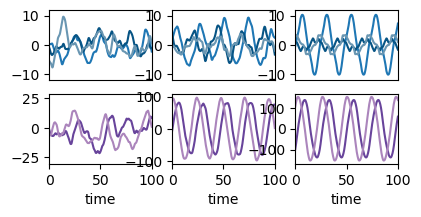

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(4.5,2))
from scipy.special import erf
phi_numpy = lambda x: erf((np.sqrt(np.pi)/2)*x)
time_vec = np.arange(0, 500, 0.05)
for i_state in range(3):
    data = np.load('packaged_results/single_neuron_decocding_test_{}.npz'.format(i_state))
    x_min = data['x_min']
    x_med = data['x_med']
    x_max = data['x_max']
    x_rand = data['x_rand']
    Z = data['Z']
    i_ax = i_state
    ax[0, i_ax].plot(time_vec, x_max, color='C0')
    #ax[0, i_ax].plot(time_vec, phi_numpy(x_max), color='#E79726')
    ax[0, i_ax].plot(time_vec, x_med, color='#075484')
    #ax[0, i_ax].plot(time_vec, phi_numpy(x_med), color='#E79726')
    ax[0, i_ax].plot(time_vec, x_min, color='#6996B2')
    #ax[0, i_ax].plot(time_vec, phi_numpy(x_min), color='#E79726')
    ax[1, i_ax].plot(time_vec, Z[0,:,0], color='#68449B')
    ax[1, i_ax].plot(time_vec, Z[0,:,1], color='#AB85BC')
for i in range(2):
    for j in range(3):
        if i==0:
            ax[i,j].set_xticks([])
            ax[i,j].set_ylim([-12, 12])
        ax[i,j].set_xlim([0, 100])
        if i > 0:
            ax[i,j].set_xlabel('time')
#plt.tight_layout()
#fig.savefig('../figs/single_neuron_tuning_.pdf')

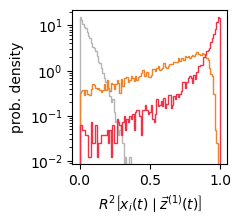

In [49]:
col1 = '#B5B5B5'
col2 = '#ED842C'
col3 = '#EE3248'
colors = [col1, col2, col3]
fig = plt.figure(figsize=(2,2))
for i_state in range(3):
    data = np.load('packaged_results/single_neuron_decocding_test_{}.npz'.format(i_state))
    plt.hist(data['R2'], histtype='step', density=True, bins=np.linspace(0, 1, 100), color=colors[i_state])
plt.xlabel(r'$R^2\left[x_i(t) \mid \vec{z}^{(1)}(t)\right]$')
plt.xticks([0, 0.5, 1])
plt.ylabel('prob. density')
plt.yscale('log')
#fig.savefig('../figs/single_neuron_hist.pdf')

In [50]:
data = np.load('packaged_results/single_neuron_decocding_test_{}.npz'.format(0))
pdf, bins = np.histogram(data['R2'], density=True, bins=np.linspace(0, 1, 100))

0.00014304843619483698


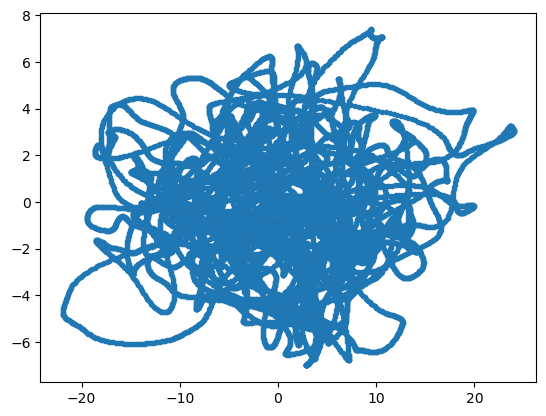

In [51]:
plt.plot(data['Z'][0,:,0], data['x_rand'], '.')
X = data['Z'][0]
y = data['x_rand']

X_ = np.column_stack([np.ones(len(X)), X])   # add intercept
beta, _, _, _ = np.linalg.lstsq(X_, y, rcond=None)
y_pred = X_ @ beta

ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - ss_res/ss_tot
print(r2)

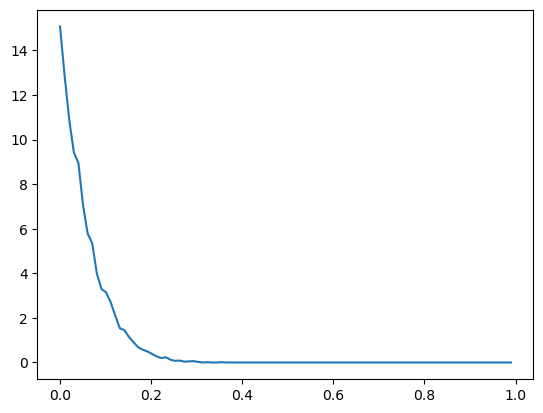

In [52]:
plt.plot(bins[:-1], pdf)

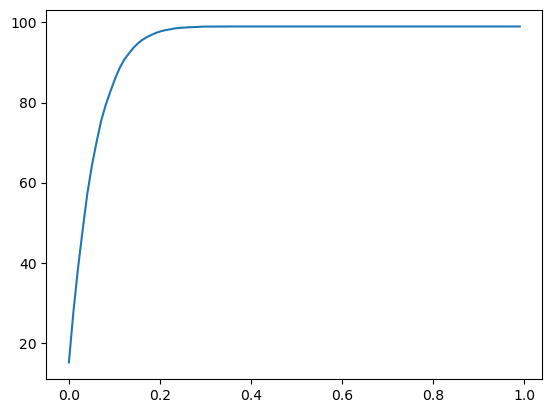

In [53]:
plt.plot(bins[:-1], np.cumsum(pdf))

In [126]:
D0 = 2.5 * D_crit_omega
Cs = np.transpose(sigma_mn_all, axes=(2,0,1))
theta0 = np.arctan(freq)
real_freq = gamma * np.cos(theta0)
i_mode = np.argmin(np.abs(np.amax(np.linalg.eigvals(Cs).real, 1) - real_freq))
D_changed = D.copy()
D_changed[i_mode] = D0
W_, all_loadings = sample_W_optimized(sigma_mn_all, D_changed, N, seed=0)

 
Z = np.einsum('air, ti -> atr', all_loadings[i_mode:i_mode+1, :, 2:4], r) * D_changed[i_mode:i_mode+1,None,None]

var_explained = []
for i in range(N):

    # assume X has shape [T,2], y has shape [T]
    X = Z[0]
    y = x[:,i]

    X_ = np.column_stack([np.ones(len(X)), X])   # add intercept
    beta, _, _, _ = np.linalg.lstsq(X_, y, rcond=None)
    y_pred = X_ @ beta

    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res/ss_tot
    var_explained.append(r2)

#     i_min = np.argsort(var_explained)[0]
#     i_med = np.argsort(var_explained)[N//2]
#     i_max = np.argsort(var_explained)[-1]

m_norm = np.linalg.norm(all_loadings[i_mode,:,:2], axis=1)
i_min = np.argsort(m_norm)[N//8]
i_med = np.argsort(m_norm)[N//2]
i_max = np.argsort(m_norm)[7*N//8]

In [28]:
m_norm[np.argsort(m_norm)[0]]

0.00019124463

In [26]:
np.amin(m_norm)

0.00019124463

In [23]:
all_loadings[i_mode,np.argsort(m_norm)[0],:]

array([-3.4363031e-05, -1.8813211e-04, -5.4360053e-04, -2.2260414e-03],
      dtype=float32)

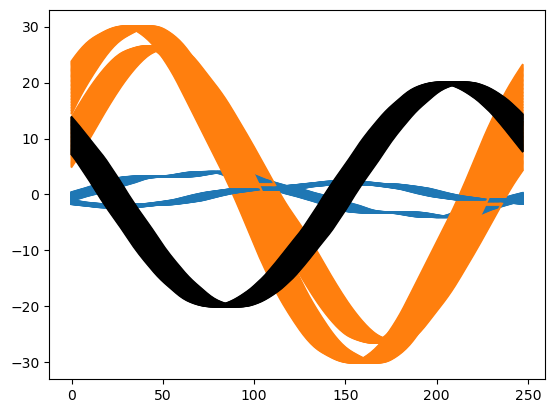

In [131]:
interval_steps = int(2*np.pi/freq * 20)-3
for i in range(2):
    x_low = x[:,np.argsort(m_norm)[i]]
    x_high = x[:,np.argsort(m_norm)[-i-1]]
    for i_int in range(x.shape[0]//interval_steps):
        plt.plot(x_low[i_int*interval_steps:(i_int+1)*interval_steps], color='C0')
        plt.plot(x_high[i_int*interval_steps:(i_int+1)*interval_steps], color='C1')
for i_int in range(x.shape[0]//interval_steps):
    plt.plot(Z[0,i_int*interval_steps:(i_int+1)*interval_steps,0]/np.amax(Z[0,:,0])*20, color='k')
    #plt.plot(x_low/x_lowcolor='C0', linewidth=1)
    #plt.plot(color='C1', linewidth=1)
#plt.plot(Z[0,:,0]/np.amax(Z[0,:,0])*30, color='k')
#plt.plot(Z[0,:,1]/np.amax(Z[0,:,1])*30, color='k')
#plt.xlim([0, 251])

(0.0, 250.0)

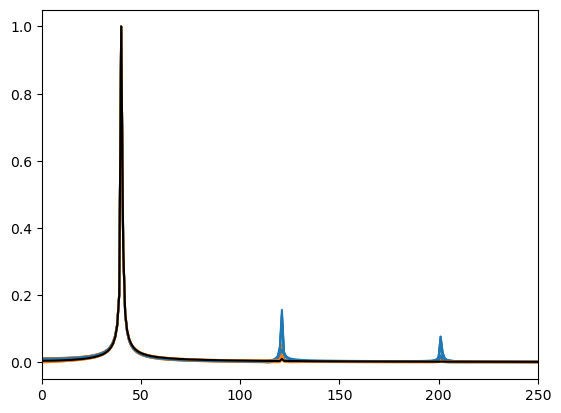

In [132]:
for i in range(5):
    x_low = x[:,np.argsort(m_norm)[i]]
    x_high = x[:,np.argsort(m_norm)[-i-1]]
    ps_low = np.abs(np.fft.rfft(x_low))
    ps_high = np.abs(np.fft.rfft(x_high))
    plt.plot(ps_low/np.amax(ps_low), color='C0')
    plt.plot(ps_high/np.amax(ps_high), color='C1')
ps_task = np.abs(np.fft.rfft(Z[0,:,0]))
plt.plot(ps_task/np.amax(ps_task), color='k')
plt.xlim([0, 250])

(array([ 2.,  4.,  5., 11., 21., 15., 28., 20., 15., 21., 17., 19.,  7.,
         9.,  4.,  1.,  0.,  0.,  0.,  1.]),
 array([ 59463.72693526,  63203.25237291,  66942.77781056,  70682.3032482 ,
         74421.82868585,  78161.3541235 ,  81900.87956114,  85640.40499879,
         89379.93043644,  93119.45587409,  96858.98131173, 100598.50674938,
        104338.03218703, 108077.55762467, 111817.08306232, 115556.60849997,
        119296.13393762, 123035.65937526, 126775.18481291, 130514.71025056,
        134254.2356882 ]),
 <BarContainer object of 20 artists>)

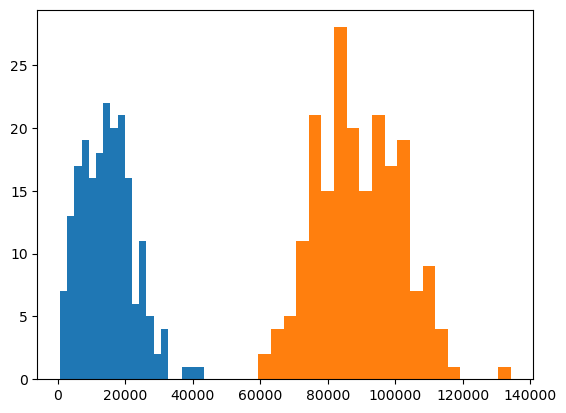

In [133]:
i_f_dom = np.argmax(ps_high)
i_f_harmonic = np.argmax(ps_high[100:150])
x_low_amplitudes = [np.abs(np.fft.rfft(x[:,np.argsort(m_norm)[i]]))[i_f_dom] for i in range(200)]
x_high_amplitudes = [np.abs(np.fft.rfft(x[:,np.argsort(m_norm)[-i-1]]))[i_f_dom] for i in range(200)]
plt.hist(x_low_amplitudes, bins=20)
plt.hist(x_high_amplitudes, bins=20)

(array([ 4., 14., 14., 24., 18., 21., 27., 14., 14., 13., 10., 10.,  6.,
         6.,  0.,  3.,  0.,  0.,  0.,  2.]),
 array([  83.85339801,  215.99129142,  348.12918482,  480.26707823,
         612.40497164,  744.54286504,  876.68075845, 1008.81865185,
        1140.95654526, 1273.09443867, 1405.23233207, 1537.37022548,
        1669.50811888, 1801.64601229, 1933.7839057 , 2065.9217991 ,
        2198.05969251, 2330.19758592, 2462.33547932, 2594.47337273,
        2726.61126613]),
 <BarContainer object of 20 artists>)

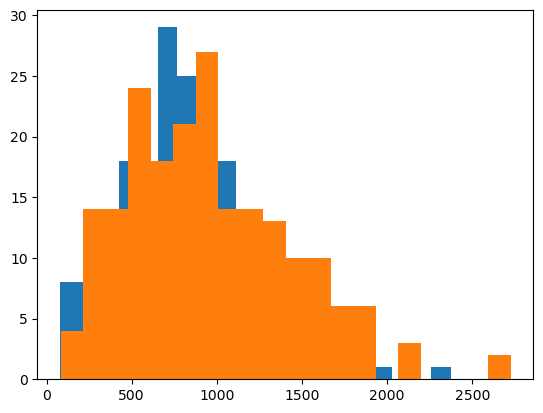

In [124]:
i_f_dom = np.argmax(ps_high)
i_f_harmonic = np.argmax(ps_high[100:150])
x_low_amplitudes = [np.abs(np.fft.rfft(x[:,np.argsort(m_norm)[i]]))[i_f_harmonic] for i in range(200)]
x_high_amplitudes = [np.abs(np.fft.rfft(x[:,np.argsort(m_norm)[-i-1]]))[i_f_harmonic] for i in range(200)]
plt.hist(x_low_amplitudes, bins=20)
plt.hist(x_high_amplitudes, bins=20)

40

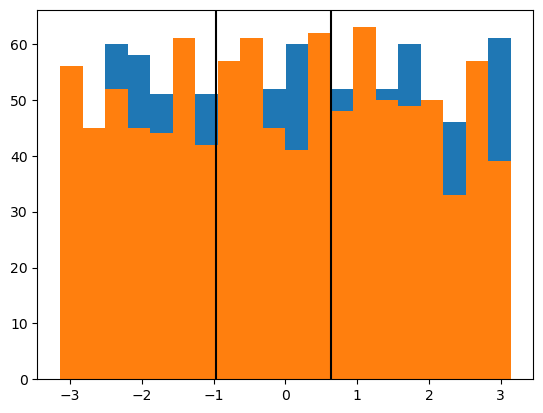

In [125]:
i_f_dom = np.argmax(ps_task)
angles_low = []
angles_high = []
for i in range(1000):
    x_low = x[:,np.argsort(m_norm)[i]]
    x_high = x[:,np.argsort(m_norm)[-i-1]]
    angle_low = np.angle(np.fft.rfft(x_low))[i_f_dom]
    angles_low.append(angle_low)
    angle_high = np.angle(np.fft.rfft(x_high))[i_f_dom]
    angles_high.append(angle_high)
plt.hist(angles_low, color='C0', bins=20)
plt.hist(angles_high, color='C1', bins=20)
angle_task_1 = np.angle(np.fft.rfft(Z[0,:,0]))[i_f_dom]
angle_task_2 = np.angle(np.fft.rfft(Z[0,:,1]))[i_f_dom]
plt.axvline(x=angle_task_1, color='k')
plt.axvline(x=angle_task_2, color='k')
#plt.xlim([0, 250])

(array([  5.,  21.,  15.,  29.,  35.,  52.,  51.,  55.,  74.,  78.,  92.,
         93.,  86.,  84.,  87.,  91.,  96., 132., 122., 112., 101., 124.,
        126., 120., 136., 118., 123., 102., 107., 125., 128., 108., 118.,
         95., 104.,  93.,  99.,  93., 107.,  91.,  80.,  77.,  86.,  58.,
         76.,  79.,  68.,  63.,  69.,  65.,  56.,  37.,  44.,  34.,  40.,
         41.,  33.,  37.,  31.,  27.,  23.,  27.,  33.,  18.,  20.,  26.,
         10.,  11.,   8.,  12.,  12.,   7.,   6.,   6.,   5.,   7.,   5.,
          5.,   3.,   1.,   5.,   3.,   4.,   5.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.00019124, 0.00075485, 0.00131845, 0.00188206, 0.00244566,
        0.00300926, 0.00357287, 0.00413647, 0.00470007, 0.00526368,
        0.00582728, 0.00639088, 0.00695449, 0.00751809, 0.0080817 ,
        0.0086453 , 0.0092089 , 0.00977251, 0.01033611, 0.01089971,
        0.01146332, 0.01202692, 0.01259053, 0.

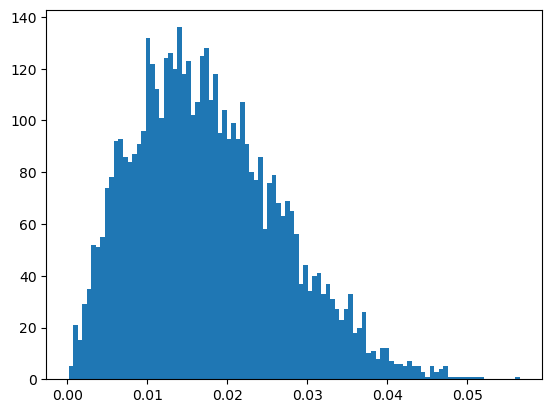

In [54]:
plt.hist(m_norm, bins=100)

In [59]:
Z = np.einsum('air, ti -> atr', all_loadings[i_mode:i_mode+1, :, 2:4], r) * D_changed[i_mode:i_mode+1,None,None]

(0.0, 200.0)

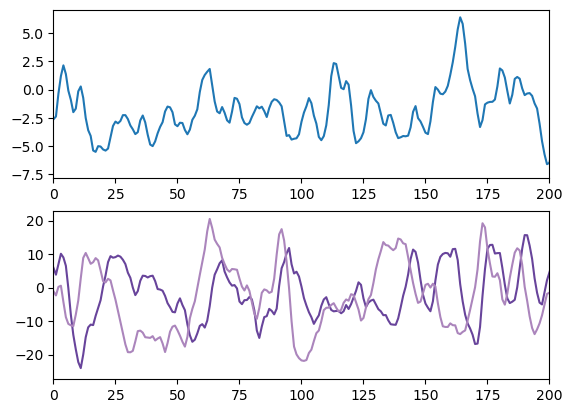

In [60]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(x[:,0])
ax[1].plot(Z[0,:,0], color='#68449B')
ax[1].plot(Z[0,:,1], color='#AB85BC')
ax[0].set_xlim([0, 200])
ax[1].set_xlim([0, 200])

(0.0, 200.0)

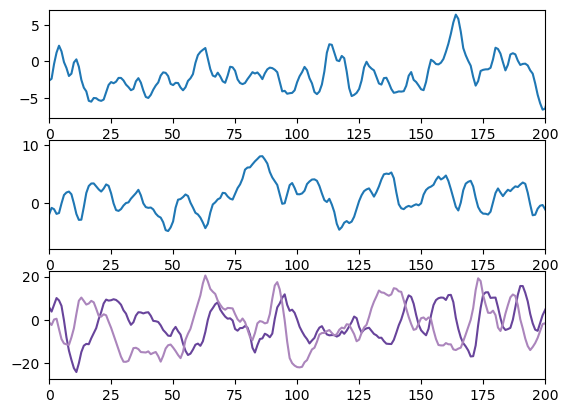

In [63]:
fig, ax = plt.subplots(3, 1)
i_min = np.argsort(var_explained)[0]
ax[0].plot(x[:,0])
ax[1].plot(x[:,i_min])
ax[2].plot(Z[0,:,0], color='#68449B')
ax[2].plot(Z[0,:,1], color='#AB85BC')
ax[0].set_xlim([0, 200])
ax[1].set_xlim([0, 200])
ax[2].set_xlim([0, 200])

In [61]:
var_explained = []
for i in range(5000):
    
    # assume X has shape [T,2], y has shape [T]
    X = Z[0]
    y = x[:,i]

    X_ = np.column_stack([np.ones(len(X)), X])   # add intercept
    beta, _, _, _ = np.linalg.lstsq(X_, y, rcond=None)
    y_pred = X_ @ beta

    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res/ss_tot
    var_explained.append(r2)

(array([2.479e+03, 1.260e+03, 6.330e+02, 3.340e+02, 1.540e+02, 8.700e+01,
        2.800e+01, 1.700e+01, 6.000e+00, 2.000e+00]),
 array([8.60139151e-06, 3.31215840e-02, 6.62345666e-02, 9.93475492e-02,
        1.32460532e-01, 1.65573514e-01, 1.98686497e-01, 2.31799480e-01,
        2.64912462e-01, 2.98025445e-01, 3.31138427e-01]),
 <BarContainer object of 10 artists>)

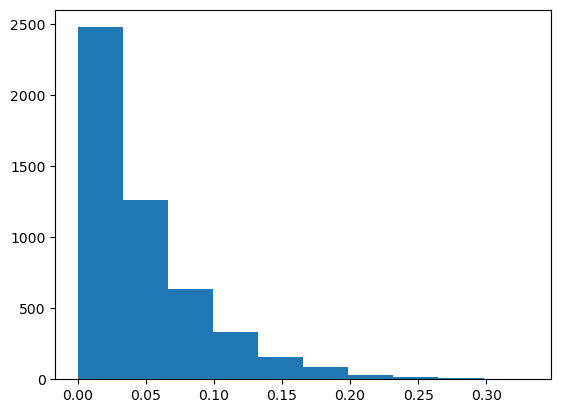

In [62]:
plt.hist(var_explained)

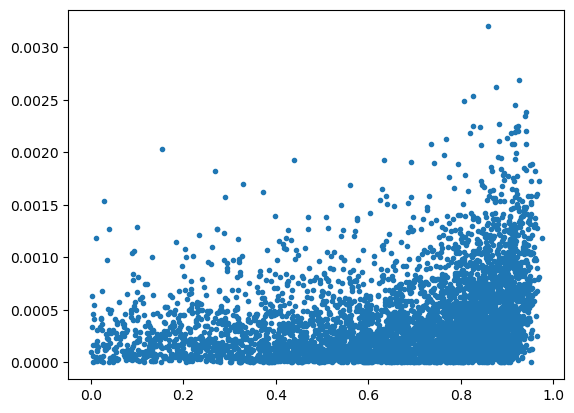

In [56]:
plt.plot(var_explained, all_loadings[i_mode,:,0]**2 + all_loadings[i_mode,:,1]**2, '.')

(array([718., 541., 519., 474., 395., 365., 301., 256., 216., 199., 145.,
        152.,  92.,  90., 103.,  73.,  70.,  46.,  41.,  31.,  38.,  25.,
         20.,  19.,   8.,  14.,  10.,  12.,   3.,   4.,   4.,   4.,   2.,
          3.,   1.,   0.,   4.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.14499098e-05, 4.94039668e-03, 9.86934345e-03, 1.47982902e-02,
        1.97272370e-02, 2.46561838e-02, 2.95851305e-02, 3.45140773e-02,
        3.94430241e-02, 4.43719708e-02, 4.93009176e-02, 5.42298644e-02,
        5.91588111e-02, 6.40877579e-02, 6.90167047e-02, 7.39456515e-02,
        7.88745982e-02, 8.38035450e-02, 8.87324918e-02, 9.36614385e-02,
        9.85903853e-02, 1.03519332e-01, 1.08448279e-01, 1.13377226e-01,
        1.18306172e-01, 1.23235119e-01, 1.28164066e-01, 1.33093013e-01,
        1.38021959e-01, 1.42950906e-01, 1.47879853e-01, 1.52808800e-01,
        1.57737747e-01, 1.62666693e-01, 1.67595640e-01, 1.72524587e-01,
        1.

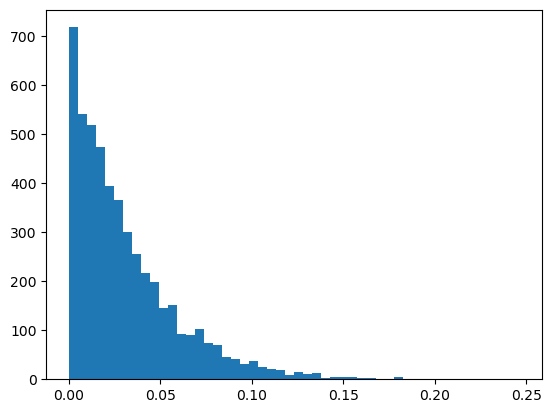

In [88]:
#plt.hist(var_explained, bins=50)

In [43]:
#i_min = np.argsort(var_explained)[0]

(0.0, 200.0)

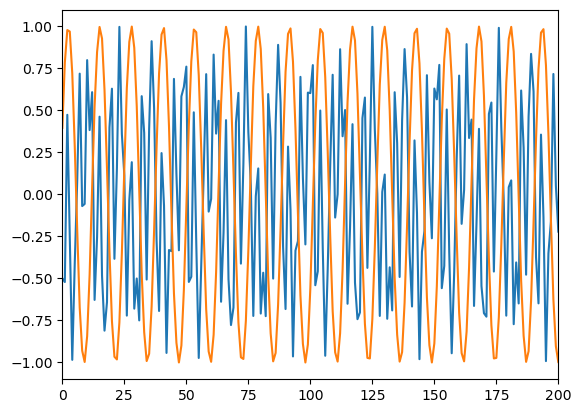

In [44]:
#plt.plot(x[:,i_min]/np.amax(x[:,i_min]))
#plt.plot(Z[0,:,0]/np.amax(Z[0,:,0]))
#plt.xlim([0,200])

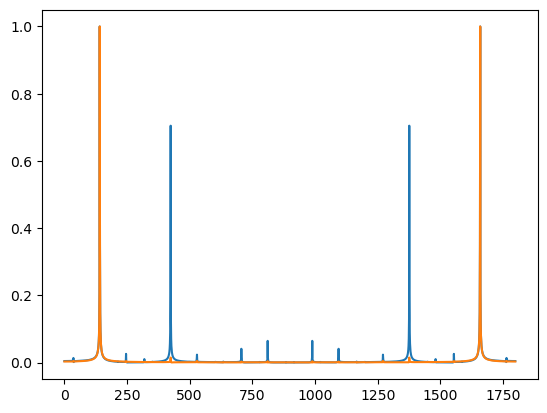

In [54]:
#Z_ft = np.abs(np.fft.fft(Z[0,:,0]))
#x_ft = np.abs(np.fft.fft(x[:,i_min+5]))
#plt.plot(x_ft/np.amax(x_ft))
#plt.plot(Z_ft/np.amax(Z_ft))

(0.0, 2500.0)

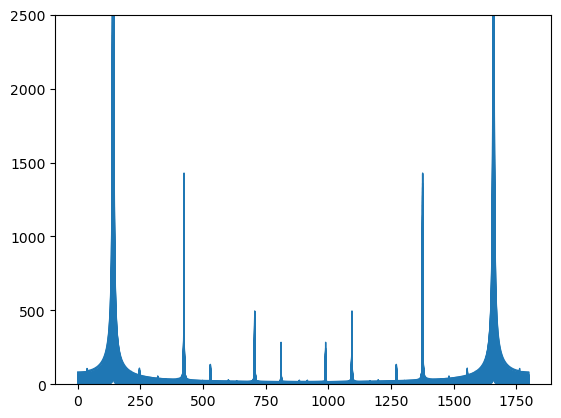

In [48]:
#X_ft = np.abs(np.fft.fft(x, axis=0))
#for i in range(1000):
#    plt.plot(X_ft[:,i], color='C0', linewidth=1, alpha=1)
#plt.ylim([0, 2500])

In [46]:
#i_min

980

(0.0, 200.0)

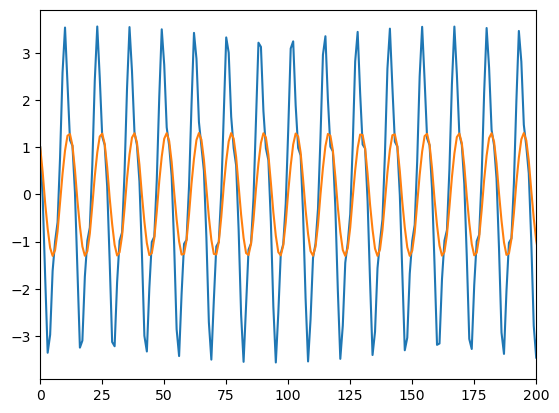

In [15]:
#plt.plot(x[:,i_min+1]/x[0,i_min+1])
#plt.plot(Z[0,:,0]/Z[0,0,0])
#plt.xlim([0,200])

In [13]:
processed_data = np.array(var_explained)

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sigma_mn_all, 'dim_emp': None,
          'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [93]:
###Truncate file above
file_name = 'Figure_7_fraction_variance'
job_name = 'frac_var_explained_2'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook Figure_7_fraction_variance.ipynb to script
[NbConvertApp] Writing 58161 bytes to Figure_7_fraction_variance.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b06c61199d0> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b06c61199d0> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [94]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1,
               results_subdir='Multi_Task_Elife')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False,
           results_subdir='Multi_Task_Elife', lkumar=True)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/Multi_Task_Elife/frac_var_explained_2/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/LDR_dim/
mft-theory/LDR_dim/__init__.py
mft-theory/LDR_dim/condensed_tasks.py
mft-theory/LDR_dim/extensive_tasks.py
mft-theory/LDR_dim/solve_ldr.ipynb
mft-theory/LDR_dim/util.py
mft-theory/LDR_dim/LDR-dim/
mft-theory/LDR_dim/LDR-dim/__init__.py
mft-theory/LDR_dim/LDR-dim/solve_ldr.ipynb
mft-theory/LDR_dim/LDR-dim/util.py


In [108]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           5065457    lkumar  jupyter   om2382  R    4:29:48      1 ax16


In [109]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'frac_var_explained_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='Multi_Task_Elife')

In [110]:
theory_results[1].shape

(26, 1, 5000)

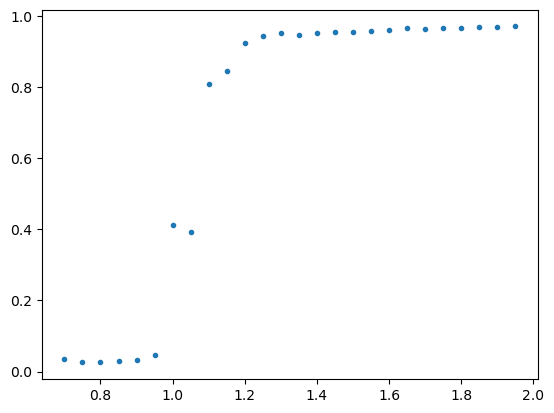

In [117]:
plt.plot(theory_results[0]['D_crit_factor'], theory_results[1][:,0,:].mean(-1), '.')

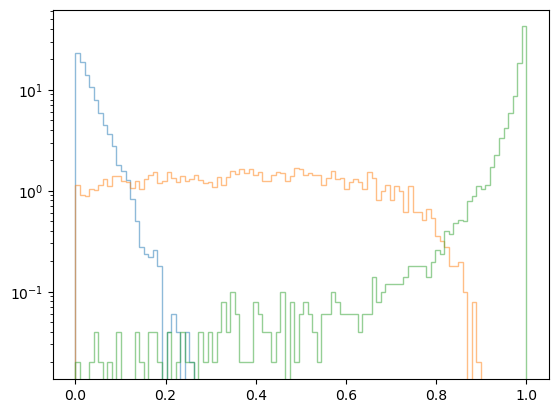

In [124]:
#for i_crit_factor in range(len(theory_results[0]['D_crit_factor'])):
for i_crit_factor in [0, 7, 15]:
    plt.hist(theory_results[1][i_crit_factor,0,:], bins=np.linspace(0, 1, 100), alpha=0.5, histtype='step', density=True)
plt.yscale('log')

In [57]:
theory_results[0]

{'D_crit_factor': [0.7,
  0.71,
  0.72,
  0.73,
  0.74,
  0.75,
  0.76,
  0.77,
  0.78,
  0.79,
  0.8,
  0.81,
  0.82,
  0.83,
  0.84,
  0.85,
  0.86,
  0.87,
  0.88,
  0.89,
  0.9,
  0.91,
  0.92,
  0.93,
  0.94,
  0.95,
  0.96,
  0.97,
  0.98,
  0.99,
  1.0,
  1.01,
  1.02,
  1.03,
  1.04,
  1.05,
  1.06,
  1.07,
  1.08,
  1.09,
  1.1,
  1.11,
  1.12,
  1.13,
  1.14,
  1.15,
  1.16,
  1.17,
  1.18,
  1.19,
  1.2,
  1.21,
  1.22,
  1.23,
  1.24,
  1.25,
  1.26,
  1.27,
  1.28,
  1.29,
  1.3,
  1.31,
  1.32,
  1.33,
  1.34,
  1.35,
  1.36,
  1.37,
  1.38,
  1.39,
  1.4,
  1.41,
  1.42,
  1.43,
  1.44,
  1.45,
  1.46,
  1.47,
  1.48,
  1.49],
 'i_seed': [0]}

Text(0, 0.5, '$D^{(\\mu)}$')

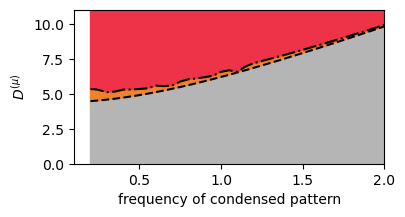

In [26]:
col1 = '#B5B5B5'
col2 = '#ED842C'
col3 = '#EE3248'
i_crit = 4
fig = plt.figure(figsize=(4, 2))
plt.plot(theory_results[0]['freq'], theory_results[1][:,i_crit,0,0], color='k', linestyle='--')
plt.plot(theory_results[0]['freq'], theory_results[1][:,i_crit,0,1], color='k', linestyle='dashdot')
plt.fill_between(theory_results[0]['freq'],
                 np.zeros_like(theory_results[0]['freq']),
                 theory_results[1][:,i_crit,0,0], color=col1)
plt.fill_between(theory_results[0]['freq'],
                 theory_results[1][:,i_crit,0,0],
                 theory_results[1][:,i_crit,0,1], color=col2)
plt.fill_between(theory_results[0]['freq'],
                 theory_results[1][:,i_crit,0,1],
                 25*np.ones_like(theory_results[0]['freq']), color=col3)
#plt.legend(['$D^{(\mu)}_{\mathrm{crit},1}$', '$D^{(\mu)}_{\mathrm{crit},2}$', 'spontaneous',
#            'structured chaos', 'deterministic'], loc='lower right')
plt.ylim([0, 11])
plt.xlim([0.1, 2])
plt.xlabel('frequency of condensed pattern')
plt.ylabel('$D^{(\mu)}$')
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0])
#plt.ylim([5, 12])
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1]/theory_results[1][:,0,0])
#plt.annotate('deterministic', xy=[2, 20])

Text(0, 0.5, '$D^{(\\mu)}$')

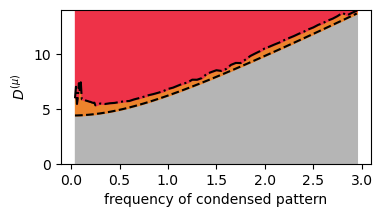

In [40]:
col1 = '#B5B5B5'
col2 = '#ED842C'
col3 = '#EE3248'
fig = plt.figure(figsize=(4, 2))
plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0], color='k', linestyle='--')
plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1], color='k', linestyle='dashdot')
plt.fill_between(theory_results[0]['freq'],
                 np.zeros_like(theory_results[0]['freq']),
                 theory_results[1][:,0,0], color=col1)
plt.fill_between(theory_results[0]['freq'],
                 theory_results[1][:,0,0],
                 theory_results[1][:,0,1], color=col2)
plt.fill_between(theory_results[0]['freq'],
                 theory_results[1][:,0,1],
                 25*np.ones_like(theory_results[0]['freq']), color=col3)
#plt.legend(['$D^{(\mu)}_{\mathrm{crit},1}$', '$D^{(\mu)}_{\mathrm{crit},2}$', 'spontaneous',
#            'structured chaos', 'deterministic'], loc='lower right')
plt.ylim([0, 14])
#plt.xlim([0.1, 2])
plt.xlabel('frequency of condensed pattern')
plt.ylabel('$D^{(\mu)}$')
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0])
#plt.ylim([5, 12])
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1]/theory_results[1][:,0,0])
#plt.annotate('deterministic', xy=[2, 20])

Text(0, 0.5, '$D^{(\\mu)}$')

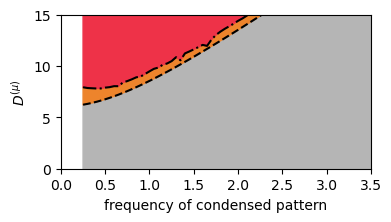

In [182]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'large_bifurfaction_frequencies_gamma_06'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='Multi_Task_Elife')

col1 = '#B5B5B5'
col2 = '#ED842C'
col3 = '#EE3248'
fig = plt.figure(figsize=(4, 2))
plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0], color='k', linestyle='--')
plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1], color='k', linestyle='dashdot')
plt.fill_between(theory_results[0]['freq'],
                 np.zeros_like(theory_results[0]['freq']),
                 theory_results[1][:,0,0], color=col1)
plt.fill_between(theory_results[0]['freq'],
                 theory_results[1][:,0,0],
                 theory_results[1][:,0,1], color=col2)
plt.fill_between(theory_results[0]['freq'],
                 theory_results[1][:,0,1],
                 25*np.ones_like(theory_results[0]['freq']), color=col3)
#plt.legend(['$D^{(\mu)}_{\mathrm{crit},1}$', '$D^{(\mu)}_{\mathrm{crit},2}$', 'spontaneous',
#            'structured chaos', 'deterministic'], loc='lower right')
plt.ylim([0, 15])
plt.xlim([0, 3.5])
plt.xlabel('frequency of condensed pattern')
plt.ylabel('$D^{(\mu)}$')
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0])
#plt.ylim([5, 12])
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1]/theory_results[1][:,0,0])
#plt.annotate('deterministic', xy=[2, 20])

In [203]:
with open('/home/om2382/low-rank-dims/results/Multi_Task_Elife/x_dim_theory_check/result_21', 'rb') as f:
    res = pickle.load(f)

In [4]:
theory_results[0]

{'N': [3000, 6000],
 'D_crit_factor': [1.0,
  1.01,
  1.02,
  1.03,
  1.04,
  1.05,
  1.06,
  1.07,
  1.08,
  1.09,
  1.1,
  1.11,
  1.12,
  1.13,
  1.14,
  1.15],
 'i_seed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

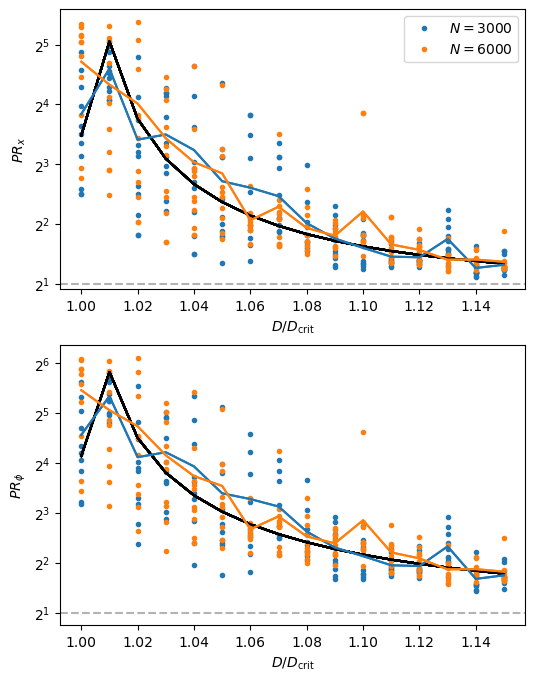

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

for i in range(2):
    ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,0,0],
             '.', alpha=1, color='C{}'.format(i))
for i in range(2):
    for i_seed in range(10):
        ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,0],
                 '.', alpha=1, color='C{}'.format(i))
        ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,1],
                 alpha=1, color='k')
        ax[1].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,2],
                 '.', alpha=1, color='C{}'.format(i))
        ax[1].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,3],
                 alpha=1, color='k')
for i in range(2):
    for i_ax in range(2):
        ax[i_ax].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,:,2*i_ax].mean(-1),
                 alpha=1, color='C{}'.format(i))
        ax[i_ax].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,:,2*i_ax].mean(-1),
                 alpha=1, color='C{}'.format(i))
#plt.yscale('log', base=2)
ax[0].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[1].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[0].set_xlabel('$D/D_\mathrm{crit}$')
ax[1].set_xlabel('$D/D_\mathrm{crit}$')
ax[0].set_ylabel('$PR_x$')
ax[1].set_ylabel('$PR_\phi$')
ax[0].legend(['$N = 3000$', '$N = 6000$'])
ax[0].set_yscale('log', base=2)
ax[1].set_yscale('log', base=2)
ax[0].axhline(y=2, linestyle='--', color=('0.7'))
ax[1].axhline(y=2, linestyle='--', color=('0.7'))
#ax[1].set_xscale('log', base=2)

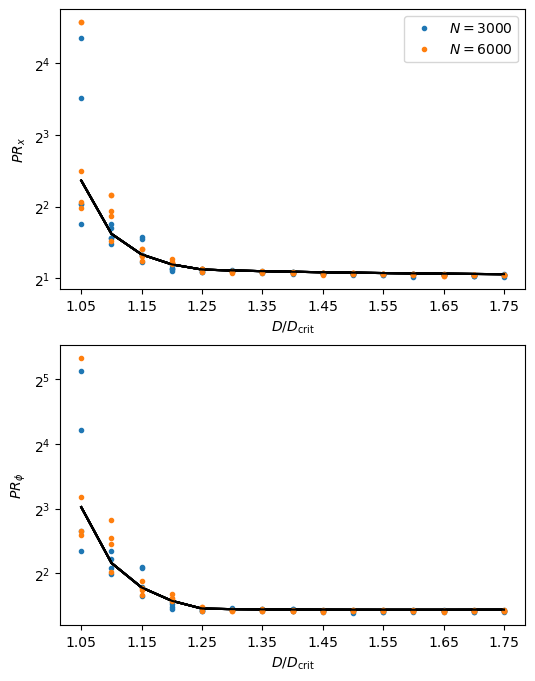

In [234]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

for i in range(2):
    ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,0,0],
             '.', alpha=1, color='C{}'.format(i))
for i in range(2):
    for i_seed in range(4):
        ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,0],
                 '.', alpha=1, color='C{}'.format(i))
        ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,1],
                 alpha=1, color='k')
        ax[1].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,2],
                 '.', alpha=1, color='C{}'.format(i))
        ax[1].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,3],
                 alpha=1, color='k')
#plt.yscale('log', base=2)
ax[0].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[1].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[0].set_xlabel('$D/D_\mathrm{crit}$')
ax[1].set_xlabel('$D/D_\mathrm{crit}$')
ax[0].set_ylabel('$PR_x$')
ax[1].set_ylabel('$PR_\phi$')
ax[0].legend(['$N = 3000$', '$N = 6000$'])
ax[0].set_yscale('log', base=2)
ax[1].set_yscale('log', base=2)
#ax[1].set_xscale('log', base=2)

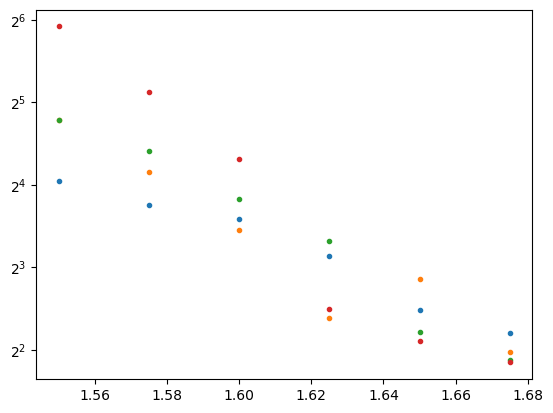

In [10]:
for i in range(4):
    plt.plot(theory_results[0]['D_1'],theory_results[1][i,:,:,0].mean(-1),
             '.', alpha=1, color='C{}'.format(i))
plt.yscale('log', base=2)

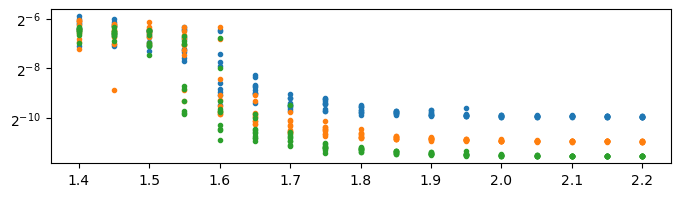

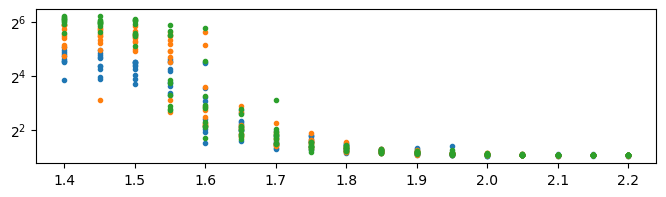

In [29]:
plt.figure(figsize=(8, 2))
for i in range(3):
    N = theory_results[0]['N'][i]
    for i_seed in range(10):
        plt.plot(theory_results[0]['D_1'], theory_results[1][i,:,i_seed,0]/N, '.', color='C{}'.format(i))
plt.yscale('log', base=2)
plt.figure(figsize=(8, 2))
for i in range(3):
    N = theory_results[0]['N'][i]
    for i_seed in range(10):
        plt.plot(theory_results[0]['D_1'], theory_results[1][i,:,i_seed,0], '.', color='C{}'.format(i))
plt.yscale('log', base=2)
#plt.yscale('log', base=2)
#plt.yticks([1, 2, 32])

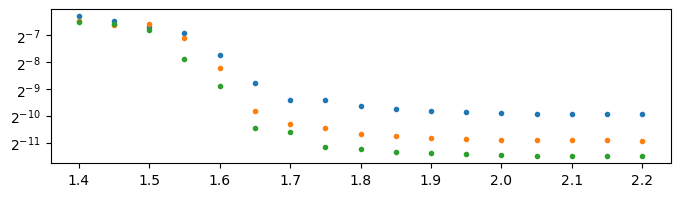

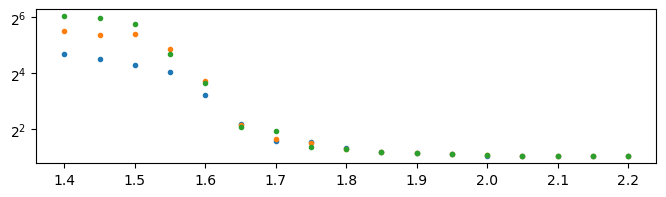

In [4]:
plt.figure(figsize=(8, 2))
for i in range(3):
    N = theory_results[0]['N'][i]
    plt.plot(theory_results[0]['D_1'], theory_results[1][i,:,:,0].mean(1)/N, '.', color='C{}'.format(i))
plt.yscale('log', base=2)
plt.figure(figsize=(8, 2))
for i in range(3):
    N = theory_results[0]['N'][i]
    plt.plot(theory_results[0]['D_1'], theory_results[1][i,:,:,0].mean(1), '.', color='C{}'.format(i))
plt.yscale('log', base=2)
#plt.yscale('log', base=2)
#plt.yticks([1, 2, 32])

(-0.04854065701365471, 0.47105365797857557)

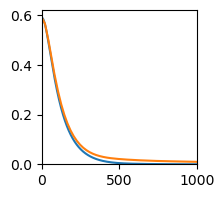

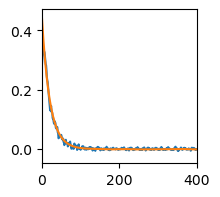

In [4]:
i_sym = 0
i_C_sigma = 0
i_PR_D = 2
plt.figure(figsize=(2, 2))
theory = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,2,:].mean(0)
sim = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,3,:].mean(0)
plt.plot(theory)
plt.plot(sim)
plt.xlim([0, 1000])
ymax = np.amax(np.concatenate([theory, sim]))
plt.ylim([0, ymax * 1.05])
plt.figure(figsize=(2, 2))
theory = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,0,:].mean(0)
sim = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,1,:].mean(0)
plt.plot(theory)
plt.plot(sim)
plt.xlim([0, 400])
ymax = np.amax(np.concatenate([theory, sim]))
ymin = np.amin(np.concatenate([theory, sim]))
plt.ylim([ymin, ymax * 1.05])

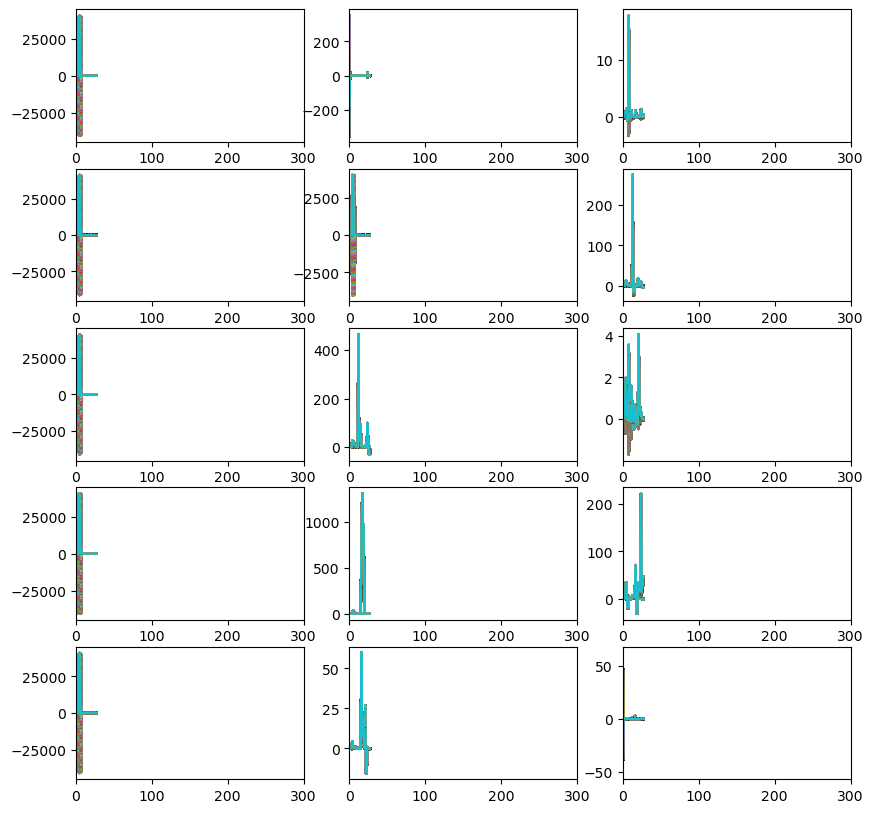

In [15]:
theory_results[1].shape
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i_sym in range(5):
    for i_g in range(3):
        ax[i_sym,i_g].plot(theory_results[1][i_sym,i_g,0,0,:])
        ax[i_sym,i_g].plot(theory_results[1][i_sym,i_g,0,1,:])
        ax[i_sym,i_g].set_xlim([0, 300])

In [ ]:
theory_results[1].shape
plt.plot(theory_results[1][0,0,0,2,:])
plt.plot(theory_results[1][0,0,0,3,:])
plt.xlim([0, 1000])

In [ ]:
#network properties size
#N = theory_results[0]['N'][i_N]

def get_activity(i_g, i_sym):
    #i_g = 0
    #i_sym = 0
    N = 5000
    phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
    phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
    g = theory_results[0]['g'][i_g]
    #g = 5
    #lags window
    T_window_emp = 1
    dT_emp = 1
    lags_emp = np.arange(0, T_window_emp, dT_emp)
    n_lags_emp = int(T_window_emp/dT_emp)

    R = 2
    #alpha = theory_results[0]['alpha'][i_alpha]
    alpha = 0.5
    N_tasks = int(alpha * N)
    PR_D = 1
    if PR_D < 1:
        beta_D = invert_PR_by_newton(PR_D)
        D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
    else:
        D = np.ones(N_tasks)
    g_correction = g / np.sqrt(np.sum(D**2)*R/N)
    D = D * g_correction

    sym = theory_results[0]['sym'][i_sym]
    sym = -1
    sigma_mn_all = np.zeros((R, R, N_tasks))
    total_attempts = 0
    for i_task in range(N_tasks):
        sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=0.6,
                                                                                     sigma_off=0.6,
                                                                                     symmetry_factor=sym,
                                                                                     traceless=False, report_attempts=True)
        total_attempts += n_attempts
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)

    ### --- Estimate S empirically --- ###

    T_sim = 400
    dt = 0.05
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]
    
    return x, r, Z

In [ ]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i_sym in range(5):
    for i_g in range(3):
        x, r, Z = get_activity(i_g, i_sym)
        ax[i_sym, i_g].plot(x[:2000,0])
        ax[i_sym, i_g].set_ylim([-15, 15])

In [ ]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i_sym in range(5):
    for i_g in range(3):
        x, r, Z = get_activity(i_g, i_sym)
        ax[i_sym, i_g].plot(Z[0,:2000,0])
        ax[i_sym, i_g].set_ylim([-15, 15])

In [46]:
###### --- Plot basic transients --- ###

i_g = 0
i_sym = 0
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 6
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 0.3
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 300
dt = 0.05
x1, r1 = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200, noise_series=None)
x0 = torch.tensor(x1[-1]).to(0)[None,:]
m1 = torch.tensor(all_loadings[0,:,0]).to(0)
n1 = torch.tensor(all_loadings[0,:,2]).to(0)
x2, r2 = sample_activity(T_sim=5, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_series=None, input_current=300*m1)
x0 = torch.tensor(x2[-1]).to(0)[None,:]
#x0 = 300*n1[None,:]
x3, r3 = sample_activity(T_sim=200, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_series=None, input_current=None)

#x = np.concatenate([x1, x3], axis=0)
#r = np.concatenate([r1, r3], axis=0)
x = np.concatenate([x1, x2, x3], axis=0)
r = np.concatenate([r1, r2, r3], axis=0)
Z = np.einsum('air, ti -> atr', all_loadings[:6, :, 2:4], r) * D[:6,None,None]

In [40]:
np.savez('packaged_results/input_drive_transients.npz', Z=Z)

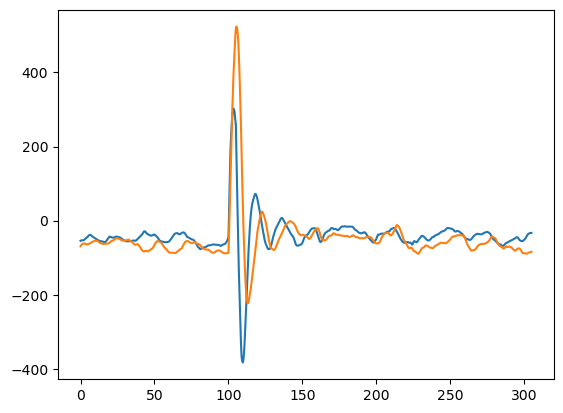

In [47]:
time_vec = np.arange(0, 305, dt)
plt.plot(time_vec, Z[0,:,0])
plt.plot(time_vec, Z[0,:,1])
#plt.xlim([50, 150])

In [75]:
### --- Plot basic transients --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 100000
dt = 0.1
x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                       runga_kutta=False, T_save_delay=200, noise_series=None)
Z = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
#plt.plot(Z[0,:,0])
#plt.plot(Z[0,:,1])

1060


In [3]:
### --- Plot basic transients --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 10000
dt = 0.1
N_runs = 50
Zs = []
for i_run in range(N_runs):
    print(i_run)
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=False, T_save_delay=10, noise_series=None)
    Z = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
    Zs.append(Z)
#plt.plot(Z[0,:,0])
#plt.plot(Z[0,:,1])

958
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [10]:
import numpy as np
import matplotlib.pyplot as plt

N = 4000

def compute_average_flow_field_cartesian_batches(all_batches, n_x_bins=20, n_y_bins=20,
                                                   x_range=(-2.0, 2.0), y_range=(-2.0, 2.0)):
    """
    Computes the average flow field over a Cartesian grid from a list of time series batches.
    Each batch is treated independently so that the end of one batch and the start of the next
    do not get connected.
    
    Parameters:
      all_batches : list of np.ndarray
          Each array is of shape (T, 2) representing a 2D trajectory for one batch.
      n_x_bins : int
          Number of bins in the x direction.
      n_y_bins : int
          Number of bins in the y direction.
      x_range : tuple (x_min, x_max)
          Range in the x direction.
      y_range : tuple (y_min, y_max)
          Range in the y direction.
          
    Returns:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      counts : np.ndarray, shape (n_x_bins, n_y_bins)
          Number of velocity samples in each cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
    """
    # Prepare arrays for accumulation.
    velocity_sum = np.zeros((n_x_bins, n_y_bins, 2))
    counts = np.zeros((n_x_bins, n_y_bins))
    
    # Define the grid edges.
    x_edges = np.linspace(x_range[0], x_range[1], n_x_bins + 1)
    y_edges = np.linspace(y_range[0], y_range[1], n_y_bins + 1)
    
    # Process each batch separately.
    for batch in all_batches:
        # Skip batches that are too short.
        if batch.shape[0] < 2:
            continue
        # Compute velocities within this batch.
        velocities = np.diff(batch, axis=0)
        # Use midpoints of consecutive points for binning.
        positions = 0.5 * (batch[:-1] + batch[1:])
        
        for pos, vel in zip(positions, velocities):
            x, y = pos
            # Skip if outside region.
            if (x < x_range[0]) or (x > x_range[1]) or (y < y_range[0]) or (y > y_range[1]):
                continue
            # Determine bin indices.
            x_bin = int(np.floor((x - x_range[0]) / (x_range[1] - x_range[0]) * n_x_bins))
            y_bin = int(np.floor((y - y_range[0]) / (y_range[1] - y_range[0]) * n_y_bins))
            # Handle edge cases.
            if x_bin == n_x_bins:
                x_bin = n_x_bins - 1
            if y_bin == n_y_bins:
                y_bin = n_y_bins - 1
            # Accumulate.
            velocity_sum[x_bin, y_bin] += vel
            counts[x_bin, y_bin] += 1
    
    # Compute the average velocities where counts > 0.
    avg_flow = np.zeros_like(velocity_sum)
    mask = counts > 0
    avg_flow[mask] = velocity_sum[mask] / counts[mask, None]
    
    return avg_flow, counts, x_edges, y_edges

def plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=None, limit_cycle=None, plot_only_first=True, fp=None, Z_long=None,
                                     z_labels=None, sqrt_ticks=True, plot_arrows=False):
    """
    Plots the average flow field on a Cartesian grid using streamplot.
    
    Parameters:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
      density : float
          Controls the closeness of streamlines.
      linewidth : float
          Line width of the streamlines.
      arrowsize : float
          Size of the arrows.
    """
    # Compute bin centers.
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    
    # Extract averaged velocity components.
    U = avg_flow[:, :, 0]
    V = avg_flow[:, :, 1]
    
    # For streamplot, provide 1D coordinate arrays and transpose U and V.
    fig = plt.figure(figsize=(5, 5))
    if Z is not None:
        for z in Z:
            plt.plot(z[:,0], z[:,1], color='#AC85BC', alpha=1, linewidth=1, zorder=2)
            if plot_arrows:
                # Compute directional differences between successive points
                dx = np.diff(z[:, 0])
                dy = np.diff(z[:, 1])
                speed = np.sqrt(dx**2 + dy**2)
                dx = dx/speed
                dy = dy/speed

                # Choose arrow placement interval (adjust based on your data density)
                arrow_interval = max(1, len(z) // 20)

                # Plot arrows using quiver. We use z[:-1] since np.diff returns one fewer element.
                plt.quiver(z[:-1:arrow_interval, 0], z[:-1:arrow_interval, 1],
                           dx[::arrow_interval], dy[::arrow_interval],
                           color='#AC85BC', scale_units='xy', angles='xy', scale=0.8,
                            width=0.008,         # Arrow shaft thickness
                            headwidth=15,         # Width of the arrow head
                            headlength=15,        # Length of the arrow head
                            headaxislength=15, zorder=3)

            
            if plot_only_first:
                break
    speed = np.log10(np.sqrt(U**2 + V**2) + 0.001)
    plt.streamplot(x_centers, y_centers, U.T, V.T, density=density,
                   color=speed, cmap='Greys', linewidth=linewidth, arrowsize=arrowsize)

    if limit_cycle is not None:
        plt.plot(limit_cycle[:,0], limit_cycle[:,1], color='k', linestyle='--', linewidth=0.8)
    if fp is not None:
        for fp_ in fp:
            plt.plot([fp_[0]], [fp_[1]], 'x', color='k', markersize=3)
    if Z_long is not None:
        plt.plot(Z_long[:,0], Z_long[:,1], color='#AC85BC', linewidth=0.7)
    if z_labels==1:
        plt.xlabel('$z^{(1)}_1(t)$', fontsize=8)
        plt.ylabel('$z^{(1)}_2(t)$', fontsize=8)
    elif z_labels==2:
        plt.xlabel('$z^{(2)}_1(t)$', fontsize=8)
        plt.ylabel('$z^{(2)}_2(t)$', fontsize=8)
    else:
        plt.xlabel('$z_1(t)$', fontsize=8)
        plt.ylabel('$z_2(t)$', fontsize=8)
    #plt.title('Average Flow Field (Cartesian Grid, Batches)')
    if sqrt_ticks:
        plt.xticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=8)
        plt.yticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=8)
    else:
        pass
    plt.axis('equal')
    plt.show()
    
    return fig

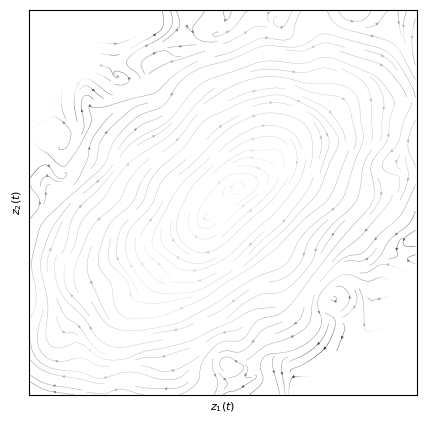

In [11]:
R = 15
x_range = (-R, R)
y_range = (-R, R)

all_batches = [zs[1] for zs in Zs]

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=0.3, arrowsize=0.4,
                                       Z=None, plot_only_first=False)

In [4]:
all_batches = Z[None,:0,:,:]

R = 2
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                 Z=None, Z_long=None)

NameError: name 'compute_average_flow_field_cartesian_batches' is not defined

In [76]:
np.savez('packaged_results/MalphaN_limcyc_fp_2', Z=Z)

In [77]:
!du -sh packaged_results/MalphaN_limcyc_fp.npz

10M	packaged_results/MalphaN_limcyc_fp.npz


In [14]:
### --- M = 1 network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
#sigma_mn_all[:,:,1] = np.array([[0.55, 0.4],[0.4, 0.55]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 20
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_[0])
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

0


In [15]:
np.savez('packaged_results/M=1_network_3', Zs=Zs, Z_long=Z_long)

In [55]:
### --- M = 2 network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 2
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 40
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0_1 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0_2 = torch.tensor(all_loadings[1,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0 = x0_1 + x0_2
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long2 = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]

2


In [57]:
np.savez('packaged_results/M=2_network_limcyc_fp', Zs=Zs, Z_long=Z_long, Z_long2=Z_long2)

In [58]:
### --- M = 1 network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
#N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
#D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
#sigma_mn_all[:,:,0] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 20
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

1


In [59]:
np.savez('packaged_results/M=1_network_fp', Zs=Zs, Z_long=Z_long)

In [ ]:
### --- M = \alpha N network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
#sigma_mn_all[:,:,1] = np.array([[0.55, 0.4],[0.4, 0.55]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 20
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_[0])
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

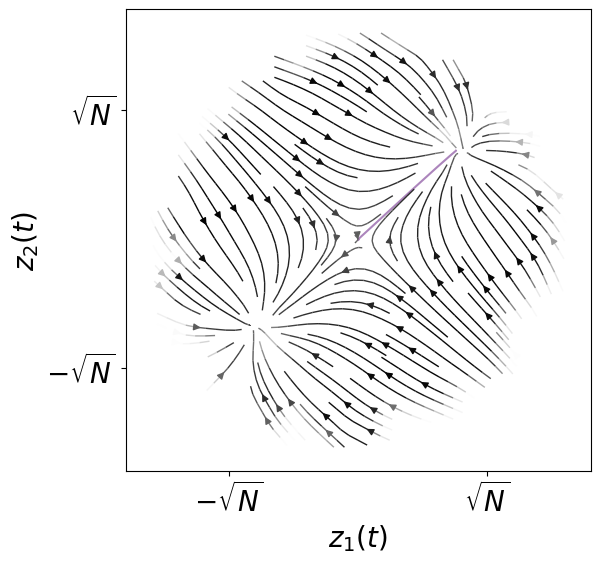

In [52]:
all_batches = Zs[:,0,:,:]

R = 120
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                 Z=None, Z_long=Z_long[0])

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def compute_average_flow_field_cartesian_batches(all_batches, n_x_bins=20, n_y_bins=20,
                                                   x_range=(-2.0, 2.0), y_range=(-2.0, 2.0)):
    """
    Computes the average flow field over a Cartesian grid from a list of time series batches.
    Each batch is treated independently so that the end of one batch and the start of the next
    do not get connected.
    
    Parameters:
      all_batches : list of np.ndarray
          Each array is of shape (T, 2) representing a 2D trajectory for one batch.
      n_x_bins : int
          Number of bins in the x direction.
      n_y_bins : int
          Number of bins in the y direction.
      x_range : tuple (x_min, x_max)
          Range in the x direction.
      y_range : tuple (y_min, y_max)
          Range in the y direction.
          
    Returns:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      counts : np.ndarray, shape (n_x_bins, n_y_bins)
          Number of velocity samples in each cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
    """
    # Prepare arrays for accumulation.
    velocity_sum = np.zeros((n_x_bins, n_y_bins, 2))
    counts = np.zeros((n_x_bins, n_y_bins))
    
    # Define the grid edges.
    x_edges = np.linspace(x_range[0], x_range[1], n_x_bins + 1)
    y_edges = np.linspace(y_range[0], y_range[1], n_y_bins + 1)
    
    # Process each batch separately.
    for batch in all_batches:
        # Skip batches that are too short.
        if batch.shape[0] < 2:
            continue
        # Compute velocities within this batch.
        velocities = np.diff(batch, axis=0)
        # Use midpoints of consecutive points for binning.
        positions = 0.5 * (batch[:-1] + batch[1:])
        
        for pos, vel in zip(positions, velocities):
            x, y = pos
            # Skip if outside region.
            if (x < x_range[0]) or (x > x_range[1]) or (y < y_range[0]) or (y > y_range[1]):
                continue
            # Determine bin indices.
            x_bin = int(np.floor((x - x_range[0]) / (x_range[1] - x_range[0]) * n_x_bins))
            y_bin = int(np.floor((y - y_range[0]) / (y_range[1] - y_range[0]) * n_y_bins))
            # Handle edge cases.
            if x_bin == n_x_bins:
                x_bin = n_x_bins - 1
            if y_bin == n_y_bins:
                y_bin = n_y_bins - 1
            # Accumulate.
            velocity_sum[x_bin, y_bin] += vel
            counts[x_bin, y_bin] += 1
    
    # Compute the average velocities where counts > 0.
    avg_flow = np.zeros_like(velocity_sum)
    mask = counts > 0
    avg_flow[mask] = velocity_sum[mask] / counts[mask, None]
    
    return avg_flow, counts, x_edges, y_edges

def plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=None, Z_long=None):
    """
    Plots the average flow field on a Cartesian grid using streamplot.
    
    Parameters:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
      density : float
          Controls the closeness of streamlines.
      linewidth : float
          Line width of the streamlines.
      arrowsize : float
          Size of the arrows.
    """
    # Compute bin centers.
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    
    # Extract averaged velocity components.
    U = avg_flow[:, :, 0]
    V = avg_flow[:, :, 1]
    
    # For streamplot, provide 1D coordinate arrays and transpose U and V.
    plt.figure(figsize=(6, 6))
    if Z is not None:
        for z in Z:
            plt.plot(z[:,0], z[:,1], color='#AC85BC', alpha=0.3)
            #plt.plot(z[:,0], z[:,1], color='#AC85BC', alpha=1, linewidth=1.5)
            #break
    if Z_long is not None:
        plt.plot(Z_long[:,0], Z_long[:,1], color='#AC85BC', linewidth=1.5)
    speed = np.log10(np.sqrt(U**2 + V**2) + 0.001)
    plt.streamplot(x_centers, y_centers, U.T, V.T, density=density,
                   color=speed, cmap='Greys', linewidth=linewidth, arrowsize=arrowsize)

    plt.xlabel('$z_1(t)$', fontsize=20)
    plt.ylabel('$z_2(t)$', fontsize=20)
    #plt.title('Average Flow Field (Cartesian Grid, Batches)')
    plt.xticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=20)
    plt.yticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=20)
    plt.axis('equal')
    plt.show()

# Example usage
if __name__ == '__main__':

    all_batches = Zs[:,1,:,:]
    
    R = 120
    x_range = (-R, R)
    y_range = (-R, R)
    
    # Compute the flow field for the distinct batches.
    avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
        all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)
    
    # Plot the flow field using a streamplot.
    plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=Zs[:,1,:,:], Z_long=Z_long2[1])


IndexError: index 1 is out of bounds for axis 1 with size 1

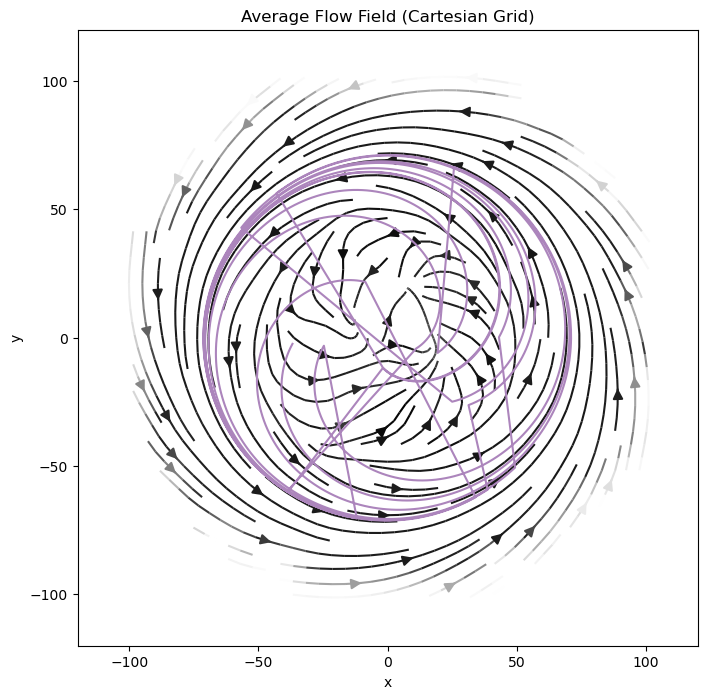

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def compute_average_flow_field_cartesian(all_series, n_x_bins=20, n_y_bins=20, x_range=(-2.0, 2.0), y_range=(-2.0, 2.0)):
    """
    Computes the average flow field over a Cartesian grid from a list of time series.

    Parameters:
      all_series : list of np.ndarray
          Each array is of shape (T, 2) representing a 2D trajectory.
      n_x_bins : int
          Number of bins in the x direction.
      n_y_bins : int
          Number of bins in the y direction.
      x_range : tuple (x_min, x_max)
          Range in the x direction.
      y_range : tuple (y_min, y_max)
          Range in the y direction.
          
    Returns:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      counts : np.ndarray, shape (n_x_bins, n_y_bins)
          Number of velocity samples in each cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
    """
    # Create arrays to accumulate velocity sums and counts.
    velocity_sum = np.zeros((n_x_bins, n_y_bins, 2))
    counts = np.zeros((n_x_bins, n_y_bins))
    
    # Define grid edges.
    x_edges = np.linspace(x_range[0], x_range[1], n_x_bins + 1)
    y_edges = np.linspace(y_range[0], y_range[1], n_y_bins + 1)
    
    for series in all_series:
        # Compute finite-difference velocities.
        velocities = np.diff(series, axis=0)
        # Compute midpoints between consecutive points.
        positions = 0.5 * (series[:-1] + series[1:])
        
        for pos, vel in zip(positions, velocities):
            x, y = pos
            # Skip if the position is out of the defined range.
            if (x < x_range[0]) or (x > x_range[1]) or (y < y_range[0]) or (y > y_range[1]):
                continue
            # Find the corresponding bin indices for x and y.
            x_bin = int(np.floor((x - x_range[0]) / (x_range[1] - x_range[0]) * n_x_bins))
            y_bin = int(np.floor((y - y_range[0]) / (y_range[1] - y_range[0]) * n_y_bins))
            # Handle edge cases where position equals the upper bound.
            if x_bin == n_x_bins:
                x_bin = n_x_bins - 1
            if y_bin == n_y_bins:
                y_bin = n_y_bins - 1
            # Accumulate velocity and count.
            velocity_sum[x_bin, y_bin] += vel
            counts[x_bin, y_bin] += 1
    
    # Compute average velocity where counts > 0.
    avg_flow = np.zeros_like(velocity_sum)
    mask = counts > 0
    avg_flow[mask] = velocity_sum[mask] / counts[mask, None]
    
    return avg_flow, counts, x_edges, y_edges

def plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=None):
    """
    Plots the average flow field on a Cartesian grid using streamplot.
    
    Parameters:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
      density : float
          Controls the closeness of streamlines.
      linewidth : float
          Line width of the streamlines.
      arrowsize : float
          Size of the arrows.
    """
    # Compute bin centers from the edges.
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    
    # Extract averaged velocity components.
    U = avg_flow[:, :, 0]
    V = avg_flow[:, :, 1]
    
    # Note: When providing 1D coordinate arrays, U and V need shape (len(y_centers), len(x_centers)).
    # Our U and V are of shape (n_x_bins, n_y_bins), so we transpose them.
    plt.figure(figsize=(8, 8))
    speed = np.log10(np.sqrt(U**2 + V**2) + 0.001)
    plt.streamplot(x_centers, y_centers, U.T, V.T, density=density, color=speed,
                   linewidth=linewidth, arrowsize=arrowsize, cmap='Greys')
    if Z is not None:
        plt.plot(Z[:,0], Z[:,1], color='#AC85BC')
    plt.xlim([np.amin(x_edges), np.amax(x_edges)])
    plt.ylim([np.amin(y_edges), np.amax(y_edges)])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Average Flow Field (Cartesian Grid)')
    #plt.axis('equal')
    plt.show()

# Example usage
if __name__ == '__main__':
    
    all_series = [Z[0]]
    # Define Cartesian region of interest.
    R = 120
    x_range = (-R, R)
    y_range = (-R, R)
    
    # Compute the average flow field on the Cartesian grid.
    avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian(
        all_series, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)
    
    # Plot the estimated flow field using streamplot.
    plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1.5, arrowsize=1.5,
                                     Z=Z[0,:2000])
    #plt.colorbar()

In [ ]:
#smn_all = theory_results[3]['0.8_8_0']
S = torch.tensor(theory_results[1][i_sigma_off, i_seed, 0, :], dtype=torch.float32).to(0)
C = torch.tensor(theory_results[1][i_sigma_off, i_seed, 2, :], dtype=torch.float32).to(0)
N_t = C.shape[0]
#T_extra = 1000
dt = 0.05
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, dt)
C_w = uni_rfft(C, dt)

In [ ]:
Crr = np.array([[0.8, -0.4],[0.4, 0.8]])
#Crr = Crr
#Crr = Crr.T
#T = len(C_phi)
#t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
#sampfreq = 1/dT
#w = 2*np.pi*sampfreq*t_indices/T
S_omega = np.sqrt(2*np.pi)*S_.cpu().numpy()[:,None,None]
M_inv = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr[None,:,:]*S_omega)
M_invT = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr.T[None,:,:]*S_omega.conj())
z_ccov = np.zeros_like(M_inv)
for w in range(z_ccov.shape[0]):
    z_ccov[w] = D[0]**2 * M_inv[w,:,:].dot(M_invT[w,:,:]) * C_w[w].cpu().numpy()
z_ccov_w = torch.from_numpy(z_ccov).to(0)
z_ccov_T = uni_irfft(z_ccov_w, 0.05, axis=0)
#z_ccov_T = z_ccov_T.cpu().numpy()

In [ ]:
z_ccov_avg = theory_results[1][i_sigma_off, i_seed, :, :].T
T = z_ccov_T.shape[0]

i_task = 0
acov_T_11 = torch.cat([z_ccov_T[:,0,0][T//2:], z_ccov_T[:,0,0][:T//2]]).cpu().numpy()
acov_T_22 = torch.cat([z_ccov_T[:,1,1][T//2:], z_ccov_T[:,1,1][:T//2]]).cpu().numpy()
ccov_T_12 = torch.cat([z_ccov_T[:,1,0][T//2:], z_ccov_T[:,1,0][:T//2]]).cpu().numpy()
ccov_T_21 = torch.cat([z_ccov_T[:,0,1][T//2:], z_ccov_T[:,0,1][:T//2]]).cpu().numpy()
acov_avg_11 = np.concatenate([z_ccov_avg[:,4+4*i_task][-T//2:], z_ccov_avg[:,4+4*i_task][:T//2]])
acov_avg_22 = np.concatenate([z_ccov_avg[:,5+4*i_task][-T//2:], z_ccov_avg[:,5+4*i_task][:T//2]])
ccov_avg_12 = np.concatenate([z_ccov_avg[:,6+4*i_task][-T//2:], z_ccov_avg[:,6+4*i_task][:T//2]])
ccov_avg_21 = np.concatenate([z_ccov_avg[:,7+4*i_task][-T//2:], z_ccov_avg[:,7+4*i_task][:T//2]])

In [ ]:
acov_T_11.shape

In [ ]:
fig, ax = plt.subplots(2, 2)
time_vec = np.arange(-len(acov_avg_11)*dt/2, len(acov_avg_11)*dt/2, dt)
ax[0,0].plot(time_vec, acov_T_11, color='C0')
ax[0,0].plot(time_vec, acov_avg_11, color='k', linestyle='--')
ax[1,1].plot(time_vec, acov_T_22, color='C0')
ax[1,1].plot(time_vec, acov_avg_22, color='k', linestyle='--')
ax[0,1].plot(time_vec, ccov_T_12, color='C0')
ax[0,1].plot(time_vec, ccov_avg_21, color='k', linestyle='--')
ax[1,0].plot(time_vec, ccov_T_21, color='C0')
ax[1,0].plot(time_vec, ccov_avg_12, color='k', linestyle='--')
ax[0,0].set_title(r'$C^z_{11}(\tau)$')
ax[0,1].set_title(r'$C^z_{12}(\tau)$')
ax[1,0].set_title(r'$C^z_{21}(\tau)$')
ax[1,1].set_title(r'$C^z_{22}(\tau)$')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(r'$\tau$')
ax[0,0].legend(['sim', 'theory'])
plt.tight_layout()
fig.savefig('figs/cross_cov_fits.pdf')